[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/generation/langchain/handbook/xx-langchain-chunking.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/generation/langchain/handbook/xx-langchain-chunking.ipynb)


#### [LangChain Handbook](https://pinecone.io/learn/langchain)

# Preparing Text Data for use with Retrieval-Augmented LLMs

In this walkthrough we'll take a look at an example and some of the considerations when we need to prepare text data for retrieval augmented question-answering using **L**arge **L**anguage
**M**odels (LLMs).
The notebook is adapted to the use of gpt4all and Flutter documentation website from https://github.com/pinecone-io/examples/blob/master/generation/langchain/handbook/xx-langchain-chunking.ipynb and video explaination at https://www.youtube.com/watch?v=eqOfr4AGLk8


## Required Libraries


There are a few Python libraries we must `pip install` for this notebook to run, those are:


In [1]:
%pip install -qU langchain unstructured matplotlib seaborn tqdm transformers sentencepiece


Note: you may need to restart the kernel to use updated packages.


## Preparing Data


The data is getting from the [Flutter documentation website](https://github.com/flutter/website), which is hosted at https://docs.flutter.dev/ and was last updated in March 2023. The static HTML files are stored in the `site` directory.


Now we can use LangChain itself to process these docs. We do this using the `UnstructuredHTMLLoader` like so:


In [2]:
from langchain.document_loaders import UnstructuredHTMLLoader

file_paths = None
with open('html_files_index.txt', 'r') as file:
    file_paths = file.readlines()

docs = []
for i, file_path in enumerate(file_paths):
    file_path = file_path.rstrip("\n")
    doc = UnstructuredHTMLLoader(file_path).load()
    docs.extend(doc)
len(docs)


428

This leaves us with `428` processed doc pages. Let's take a look at the format each one contains:


In [3]:
docs[0]


Document(page_content='Adopt a Widget\n\nContributions\n\nHow to contribute\n\nDiscord\n\nGuidelines\n\nWays to contribute\n\nAdding code\n\nSnippets\nSample\nDartPad sample\n\n\nAdding References\nAdding more explanation to the documentation\n\nQuickstart\n\nGet the code\nOpen the code in your IDE\nMake the change\nAnalyzing and Generating API Docs\nCommit the change\nMake a pull request\n\nResources\n\nNote:\n  The Adopt a Widget program ran during the month of\n  November 2020. Thanks so much for your participation!\n  We may do something similar in the future.\n\nFlutter is an open source project hosted on GitHub\nand the API docs (generated from the source code) are\nhosted on api.flutter.dev.\nAdopting a widget and improving its documentation helps everyone!\nSo, for the month of November, we’re extending a special\ninvitation to contribute to the Flutter project by choosing\na Widget and improving its API documentation.\n\nContributions\n\n(Updated Feb 14, 2021)\n\nChinmay-KB co

We access the plaintext page content like so:


In [4]:
print(docs[221].metadata['source'])
print(docs[221].page_content)


./site/development/tools/sdk/release-notes/release-notes-1.17.0/index.html
Flutter 1.17.0 release notes

Tools

SDK

Release notes

1.17.0 release notes

Merged pull requests by label

Merged PRs by labels for flutter/flutter

tool - 435 pull request(s)
framework - 413 pull request(s)
team - 283 pull request(s)
f: material design - 204 pull request(s)
a: tests - 67 pull request(s)
f: cupertino - 53 pull request(s)
a: internationalization - 34 pull request(s)
engine - 33 pull request(s)
d: examples - 28 pull request(s)
a: accessibility - 25 pull request(s)
platform-ios - 19 pull request(s)
a: quality - 16 pull request(s)
a: text input - 15 pull request(s)
d: api docs - 13 pull request(s)
documentation - 11 pull request(s)
severe: performance - 11 pull request(s)
severe: API break - 11 pull request(s)
f: scrolling - 11 pull request(s)
t: xcode - 10 pull request(s)
will affect goldens - 9 pull request(s)
platform-web - 9 pull request(s)
a: null-safety - 8 pull request(s)
a: fidelity - 7 p

In [5]:
print(docs[5].page_content)


Implicit animations

What are implicit animations?

Example: Fade-in text effect

Fade-in (starter code)
Animate opacity with AnimatedOpacity widget

1. Pick a widget property to animate
2. Initialize a state variable for the animated property
3. Set the duration of the animation
4. Set up a trigger for the animation, and choose an end value


Fade-in (complete)
Putting it all together

Example: Shape-shifting effect

Shape-shifting (starter code)
Animate color, borderRadius, and margin with AnimatedContainer

1. Add an implicit animation
2. Set starting values for animated properties
3. Set up a trigger for the animation
4. Set duration


Shape-shifting (complete)
Using animation curves
Putting it all together

What’s next?

Welcome to the implicit animations codelab, where you learn how to use Flutter
widgets that make it easy to create animations for a specific set of properties.

Note:
  This codelab uses embedded DartPads to display examples and exercises.
  If you see empty boxes

We can also find the source of each document:


In [6]:
docs[221].metadata['source'].replace('./site', 'https://docs.flutter.dev')


'https://docs.flutter.dev/development/tools/sdk/release-notes/release-notes-1.17.0/index.html'

Looks good, we need to also consider the length of each page with respect to the number of tokens that will reasonably fit within the window of the latest LLMs. We will use `gpt4all` as an example.

To count the number of tokens that `gpt4all` will use for some text we need to initialize the `transformers.LlamaTokenizer`.


In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    "google/flan-t5-base", use_fast=True)

# create the length function
def token_len(text):
    tokens = tokenizer.encode(text)
    return len(tokens)


/home/limcheekin/ws/py/flutter-gpt/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using the `token_len` function, let's count and visualize the number of tokens across our webpages.


In [8]:
token_counts = [token_len(doc.page_content) for doc in docs]


Token indices sequence length is longer than the specified maximum sequence length for this model (2287 > 512). Running this sequence through the model will result in indexing errors


Let's see `min`, average, and `max` values:


In [9]:
print(f"""Min: {min(token_counts)}
Avg: {int(sum(token_counts) / len(token_counts))}
Max: {max(token_counts)}""")


Min: 5
Avg: 6407
Max: 397361


Now visualize:


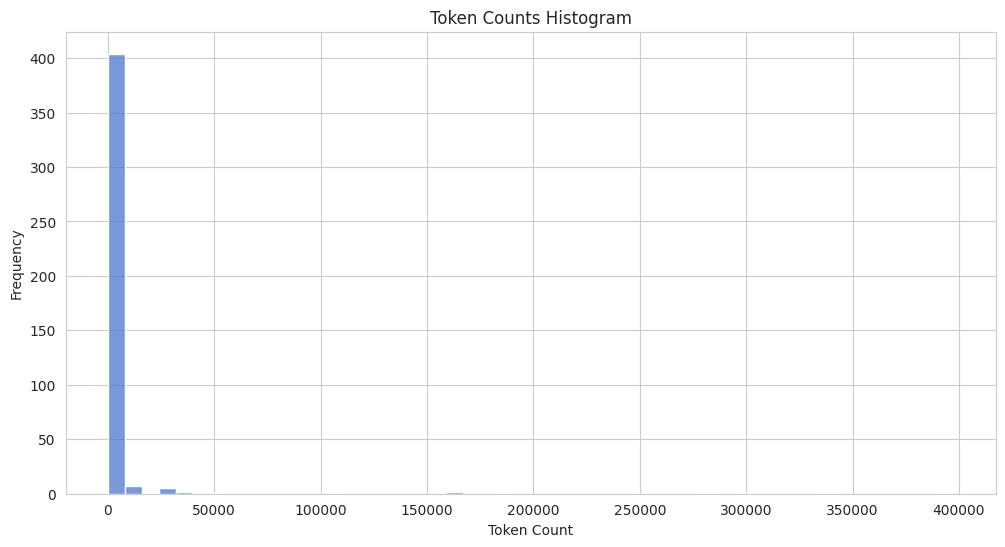

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# set style and color palette for the plot
sns.set_style("whitegrid")
sns.set_palette("muted")

# create histogram
plt.figure(figsize=(12, 6))
sns.histplot(token_counts, kde=False, bins=50)

# customize the plot info
plt.title("Token Counts Histogram")
plt.xlabel("Token Count")
plt.ylabel("Frequency")

plt.show()


The vast majority of pages seem to contain a lower number of tokens. But our limits for the number of tokens to add to each chunk is actually smaller than some of the smaller pages. But, how do we decide what this number should be?


### Chunking the Text

At the time of writing, `gpt4all` is built on `llama-7b` model which supports a context window of 2048 tokens — that means that input tokens + generated ( / completion) output tokens, cannot total more than 2048 without hitting an error.

So we 100% need to keep below this. If we assume a very safe margin of ~1000 tokens for the input prompt into `gpt4all`, leaving ~1000 tokens for conversation history and completion.

With this ~1000 token limit we may want to include _4_ snippets of relevant information, meaning each snippet can be no more than **250** token long.

To create these snippets we use the `RecursiveCharacterTextSplitter` from LangChain. To measure the length of snippets we also need a _length function_. This is a function that consumes text, counts the number of tokens within the text (after tokenization using the `llama` tokenizer), and returns that number. We define it like so:


With the length function defined we can initialize our `RecursiveCharacterTextSplitter` object like so:


In [11]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=250,
    chunk_overlap=20,  # number of tokens overlap between chunks
    length_function=token_len,
    separators=['\n\n', '\n', ' ', '']
)


Then we split the text for a document like so:


In [12]:
chunks = text_splitter.split_text(docs[5].page_content)
len(chunks)


21

In [13]:
token_len(chunks[0]), token_len(chunks[1])


(215, 151)

For `docs[5]` we created `2` chunks of token length `200` and `215`.

This is for a single document, we need to do this over all of our documents. While we iterate through the docs to create these chunks we will reformat them into a format that looks like:

```json
[
    {
        "id": "abc-0",
        "text": "some important document text",
        "source": "https://docs.flutter.dev/codelabs/implicit-animations/index.html"
    },
    {
        "id": "abc-1",
        "text": "the next chunk of important document text",
        "source": "https://docs.flutter.dev/whatnew/index.html"
    }
    ...
]
```

The `"id"` will be created based on the URL of the text + it's chunk number.


In [14]:
import hashlib
m = hashlib.md5()  # this will convert URL into unique ID

url = docs[5].metadata['source'].replace('./site', 'https://docs.flutter.dev')
print(url)

# convert URL to unique ID
m.update(url.encode('utf-8'))
uid = m.hexdigest()[:12]
print(uid)


https://docs.flutter.dev/codelabs/implicit-animations/index.html
89615a401cdb


Then use the `uid` alongside chunk number and actual `url` to create the format needed:


In [15]:
data = [
    {
        'id': f'{uid}-{i}',
        'text': chunk,
        'source': url
    } for i, chunk in enumerate(chunks)
]
data


[{'id': '89615a401cdb-0',
  'text': 'Implicit animations\n\nWhat are implicit animations?\n\nExample: Fade-in text effect\n\nFade-in (starter code)\nAnimate opacity with AnimatedOpacity widget\n\n1. Pick a widget property to animate\n2. Initialize a state variable for the animated property\n3. Set the duration of the animation\n4. Set up a trigger for the animation, and choose an end value\n\n\nFade-in (complete)\nPutting it all together\n\nExample: Shape-shifting effect\n\nShape-shifting (starter code)\nAnimate color, borderRadius, and margin with AnimatedContainer\n\n1. Add an implicit animation\n2. Set starting values for animated properties\n3. Set up a trigger for the animation\n4. Set duration\n\n\nShape-shifting (complete)\nUsing animation curves\nPutting it all together\n\nWhat’s next?\n\nWelcome to the implicit animations codelab, where you learn how to use Flutter\nwidgets that make it easy to create animations for a specific set of properties.',
  'source': 'https://docs.flu

Now we repeat the same logic across our full dataset:


In [16]:
from tqdm.auto import tqdm

documents = []

for doc in tqdm(docs):
    url = doc.metadata['source'].replace('./site', 'https://docs.flutter.dev')
    m.update(url.encode('utf-8'))
    uid = m.hexdigest()[:12]
    chunks = text_splitter.split_text(doc.page_content)
    for i, chunk in enumerate(chunks):
        documents.append({
            'id': f'{uid}-{i}',
            'text': chunk,
            'source': url
        })

len(documents)


100%|██████████| 428/428 [00:49<00:00,  8.73it/s]


13962

We're now left with `14600` documents. We can save them to a JSON lines (`.jsonl`) file like so:


In [17]:
import json

with open('train.jsonl', 'w') as f:
    for doc in documents:
        f.write(json.dumps(doc) + '\n')


To load the data from file we'd write:


In [18]:
documents = []

with open('train.jsonl', 'r') as f:
    for line in f:
        documents.append(json.loads(line))

len(documents)


13962

In [19]:
documents[0]


{'id': '780aabbc9676-0',
 'text': 'Adopt a Widget\n\nContributions\n\nHow to contribute\n\nDiscord\n\nGuidelines\n\nWays to contribute\n\nAdding code\n\nSnippets\nSample\nDartPad sample\n\n\nAdding References\nAdding more explanation to the documentation\n\nQuickstart\n\nGet the code\nOpen the code in your IDE\nMake the change\nAnalyzing and Generating API Docs\nCommit the change\nMake a pull request\n\nResources\n\nNote:\n  The Adopt a Widget program ran during the month of\n  November 2020. Thanks so much for your participation!\n  We may do something similar in the future.\n\nFlutter is an open source project hosted on GitHub\nand the API docs (generated from the source code) are\nhosted on api.flutter.dev.\nAdopting a widget and improving its documentation helps everyone!\nSo, for the month of November, we’re extending a special\ninvitation to contribute to the Flutter project by choosing\na Widget and improving its API documentation.\n\nContributions',
 'source': 'https://docs.flu

In [20]:
texts = [doc.pop('text') for doc in documents]
print(len(texts))
print(texts[0])
print(documents[0])

13962
Adopt a Widget

Contributions

How to contribute

Discord

Guidelines

Ways to contribute

Adding code

Snippets
Sample
DartPad sample


Adding References
Adding more explanation to the documentation

Quickstart

Get the code
Open the code in your IDE
Make the change
Analyzing and Generating API Docs
Commit the change
Make a pull request

Resources

Note:
  The Adopt a Widget program ran during the month of
  November 2020. Thanks so much for your participation!
  We may do something similar in the future.

Flutter is an open source project hosted on GitHub
and the API docs (generated from the source code) are
hosted on api.flutter.dev.
Adopting a widget and improving its documentation helps everyone!
So, for the month of November, we’re extending a special
invitation to contribute to the Flutter project by choosing
a Widget and improving its API documentation.

Contributions
{'id': '780aabbc9676-0', 'source': 'https://docs.flutter.dev/adoptawidget/index.html'}


### (Optional) Sharing the Dataset


We've now created our dataset and you can go ahead and use it in any way you like. However, if you'd like to share the dataset, or store it somewhere that you can get easy access to later — we can use [Hugging Face Datasets Hub](https://huggingface.co/datasets).

To begin we first need to create an account by clicking the **Sign Up** button at [huggingface.co](https://huggingface.co/). Once done we click our profile button in the same location > click **New Dataset** > give it a name like _"flutter-website-3.7"_ > set the dataset to **Public** or **Private** > click **Create dataset**.


In [21]:
%pip install datasets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 160.1 kB/s eta 0:00:000:00:01m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 3.3 MB/s eta 0:00:00m eta 0:00:010:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 2.2 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 3.0 MB/s eta 0:00:005.7 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.0/154.0 kB 2.7 MB/s eta 0:00:00m eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [22]:
from datasets import load_dataset

data = load_dataset("limcheekin/flutter-website-3.7", split="train")
data

Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 646.27it/s]
                                                                    

Dataset json downloaded and prepared to /home/limcheekin/.cache/huggingface/datasets/limcheekin___json/limcheekin--flutter-website-3.7-67082692ecece223/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e. Subsequent calls will reuse this data.


Dataset({
    features: ['id', 'text', 'source'],
    num_rows: 14600
})

In [23]:
data[0]

{'id': '780aabbc9676-0',
 'text': 'Adopt a Widget\n\nContributions\n\nHow to contribute\n\nDiscord\n\nGuidelines\n\nWays to contribute\n\nAdding code\n\nSnippets\nSample\nDartPad sample\n\n\nAdding References\nAdding more explanation to the documentation\n\nQuickstart\n\nGet the code\nOpen the code in your IDE\nMake the change\nAnalyzing and Generating API Docs\nCommit the change\nMake a pull request\n\nResources\n\nNote:\n  The Adopt a Widget program ran during the month of\n  November 2020. Thanks so much for your participation!\n  We may do something similar in the future.',
 'source': 'https://docs.flutter.dev/adoptawidget/index.html'}